# Deep neural nets for object recognition
In this exercise, you will first develop a fully connected neural net model and test it on the CIFAR-10 problem. Then, you will build a convolutional neural net model and test it on the same CIFAR-10 problem. The purpose of this exercise is to give you a working understanding of neural net models and give you experience in tuning their (many) hyper-parameters.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import copy
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# The CIFAR10 dataset
- Download and normalize the CIFAR10 dataset from torchvision
- Split the CIFAR10 data into train, validation and test set
- Set the batch size for processing these datasets
- Build the dataloaders for train, validation, and test set which will be used in the training loop
- Define the string class labels (targets are numeric 0-9)

In [ ]:
# mean and std for the RGB channels in CIFAR10
tmean = [0.49139968, 0.48215841, 0.44653091]
tstd = [0.24703223, 0.24348513, 0.26158784]

# transform the 32x32x3 images into a tensor after normalizing
# each channel using the parameters above
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(tmean, tstd)])

# download and transform the  trainset and testset for training
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

#split trainset into a train and a val set (90-10 split)
lengths = [int(p * len(trainset)) for p in [0.9,0.1]]
tr,v = torch.utils.data.random_split(trainset,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,sampler=val_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

print("Number of training batches = ",len(trainloader))
print("Number of validation batches = ",len(valloader))
print("Number of test batches = ",len(testloader))

# define the output classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:14<00:00, 12072257.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training batches =  704
Number of validation batches =  79
Number of test batches =  157


# Visualize the training data

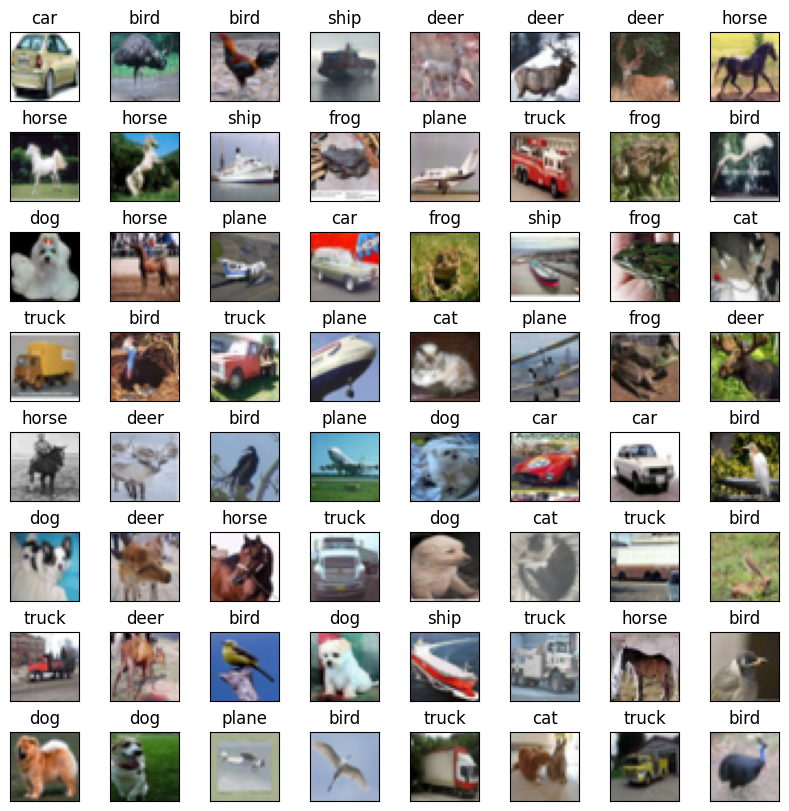

In [ ]:
Xtr,ytr = next(iter(trainloader))
# make a 8x8 grid and display 64 images from the first batch of training data
rows,cols = 8,8
fig = plt.figure(figsize=(8,8),constrained_layout=True)

for i in range(0,rows*cols):
    fig.add_subplot(rows,cols,i+1)
    tmp = np.transpose(Xtr[i].numpy(),(1,2,0))
    plt.imshow(((tmp*tstd + tmean)*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[ytr[i].numpy()])

# A five layer fully connected (FC) feedforward network
- has an input layer, two hidden layers, and an output layer
- complete the function definitions below
- you will find d2l.ai Chapters 5.2, 5.6, 6.1, 6.2, 6.3 very useful

In [ ]:
class FiveLayerFC(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes,lr,wd):
        super().__init__()
        # set up learning rate lr and weight decay wd
        # set up the network structure using nn.Sequential
        # use the ReLU non-linearity after all the hidden layers
        # use Xavier normal initialization for the weights in the hidden layers
        # use zero initialization for the bias weights
        # do not forget to Flatten the input before passing it to the first hidden layer
        # YOUR CODE HERE
        self.lr = lr
        self.wd = wd
        self.net = nn.Sequential(nn.Flatten(),
                                   nn.Linear(input_size, hidden_size1),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size1, hidden_size2),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size2, num_classes))
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
                #print(layer.bias)

        # CODE END

    def forward(self, x):
        # forward propagate the input x through the network
        # output should be a vector of dimension 10
        # YOUR CODE HERE
        return self.net(x)

        # CODE END

    def loss(self,yhat,y,averaged=True):
        # use nn.functional.cross_entropy() to evaluate loss with prediction (yhat)
        # and truth (y). Average it over a batch.
        # YOUR CODE HERE
        loss = nn.functional.cross_entropy(yhat, y, reduction='mean' if averaged else 'none')
        return loss
        # CODE END

    def predict(self, x):

       # propagate x forward and return the index of the
       # the highest valued output component
       # YOUR CODE HERE
       return self.forward(x).argmax(axis=1)
       # CODE END

    def configure_optimizers(self):
        # set up the Adam optimizer with learning rate and weight decay specified
        # in the model object
        # YOUR CODE HERE
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        # CODE END


# Test the FiveLayerFC class
- set the device to GPU if you have access to it.
- In Google Colab, you can select runtime, and pick the free T4 GPU choice.
- to understand how GPU memory and CPU memory interact, read Section 6.7 of the d2l.ai textbook.

In [ ]:
lr = 1e-2
wd = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

def test_FiveLayerFC(lr,wd):
    input_size = 32*32*3
    x = torch.zeros((64, input_size), dtype=torch.float).to(device)  # minibatch size 64, feature dimension 50
    model = FiveLayerFC(input_size, 100, 100,10,lr,wd).to(device)
    outputs = model(x)
    print(outputs.size())  # you should see [64, 10]

test_FiveLayerFC(lr,wd)

Device is:  cuda
torch.Size([64, 10])


# Checking the network setup
As a sanity check, make sure you can overfit a small dataset of 64 images. We will use a five-layer network with 100 units in the two hidden layers. You will need to tweak the learning rate and weight decay, but you should be able to overfit and achieve 100% training accuracy within 20 epochs. We have given you parameter choices that work. **You should report on at least another choice of learning rate and weight decay that allows you to fit the training data to 100% accuracy within 20 epochs.**

Complete the function train_model_small that takes a single batch (Xtr,ytr) of 64 images and their labels for training, and a single batch (Xval,yval) of validation images and trains an initialized model for num_epochs epochs.

- Initialize train_loss and val_loss (which will hold training and validation set loss for each epoch)
- Configure optimizer for the model
- for epoch in range(num_epochs)
    - zero out gradients in the optimizer
    - compute output of network by forward propagating Xtr through network
    - compute loss using output and ytr
    - backpropagate the loss
    - store the training loss for this epoch
    - compute validation set loss for this epoch (remember to turn off gradient update with torch.no_grad())
- return model, train_loss and val_loss


  0%|          | 0/20 [00:00<?, ?it/s]

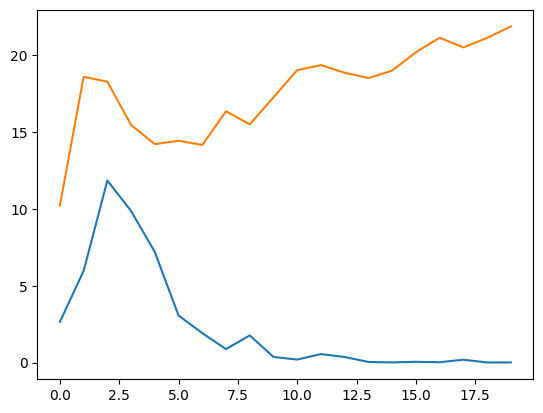

In [ ]:
Xtr,ytr = next(iter(trainloader))
Xval, yval = next(iter(valloader))
num_epochs = 20

lr = 0.01
wd = 0.001

def train_model_small(model,Xtr,ytr,Xval,yval,num_epochs):

    # YOUR CODE HERE
    train_loss = torch.empty(num_epochs)
    val_loss = torch.empty(num_epochs)
    optimizer = model.configure_optimizers()

    for epoch in tqdm(range(num_epochs)):
      optimizer.zero_grad()
      # compute output of model on X
      yhat_train = model.forward(Xtr)
      # compute loss on output and y
      epoch_loss = model.loss(yhat_train, ytr)
      train_loss[epoch] = epoch_loss.item()
      # perform backward() step on loss
      epoch_loss.backward()
      # update parameters with optimizer.step()
      optimizer.step()



      with torch.no_grad():
        yhat_val = model.forward(Xval)
        val_loss[epoch] = model.loss(yhat_val, yval)

    return model, train_loss, val_loss
    # END YOUR CODE

model = FiveLayerFC(32*32*3,100,100,10,lr,wd)
model,train_loss,val_loss = train_model_small(model,Xtr,ytr,Xval,yval,num_epochs)
plt.plot(torch.arange(num_epochs),train_loss, val_loss)

# Test your model on the training set
- you should get 100% accuracy

In [ ]:
with torch.no_grad():
    ypred = model.predict(Xtr)

    cm = sklearn.metrics.confusion_matrix(ytr,ypred)
    acc = sklearn.metrics.accuracy_score(ytr,ypred)
    print('Accuracy on test set = ',acc)
    print(cm)
    print(sklearn.metrics.classification_report(ytr,ypred))

Accuracy on test set =  1.0
[[ 8  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         8

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        

# Train the full model
- Initialize train_loss and val_loss (which will hold training and validation set loss for each epoch)
- Configure optimizer for the model
- for epoch in range(num_epochs)
    - for each batch (Xtr,ytr) in training set
       - zero out gradients in the optimizer
       - compute output of network by forward propagating Xtr through network
       - compute loss using output and ytr
       - backpropagate the loss
       - accumulate the training loss for this batch
    - store training loss for this epoch
    - compute validation set loss for this epoch (remember to turn off gradient update with torch.no_grad()) and remember to iterate over all the batches of the validation set
    
- return model, train_loss and val_loss


In [ ]:
def train_model(model,trainloader,valloader,num_epochs):
    # Initialize train_loss and val_loss (which will hold training and validation set loss for each epoch)
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    # Configure optimizer for the model
    optimizer = model.configure_optimizers()

    for epoch in tqdm(range(num_epochs)):
      # for each batch (Xtr,ytr) in training set
      epoch_batch_loss = 0
      for Xtr, ytr in trainloader:
        Xtr, ytr = Xtr.to(device), ytr.to(device)
        # zero out gradients in the optimizer
        optimizer.zero_grad()

        # compute output of network by forward propagating Xtr through network
        yhat_train = model.forward(Xtr)

        # compute loss using output and ytr
        batch_train_loss = model.loss(yhat_train, ytr)

        # backpropagate the loss
        batch_train_loss.backward()
        optimizer.step()

        # accumulate the training loss for this batch
        epoch_batch_loss += batch_train_loss.item()

      # store training loss for this epoch
      train_loss[epoch] = epoch_batch_loss/len(trainloader)

      with torch.no_grad():
        #compute validation set loss for this epoch
        epoch_val_loss = 0
        for Xval, yval in valloader:
          Xval, yval = Xval.to(device), yval.to(device)
          yhat_val = model.forward(Xval)
          batch_val_loss = model.loss(yhat_val, yval)
          epoch_val_loss += batch_val_loss.item()

        val_loss[epoch] = epoch_val_loss/len(valloader)


    return model, train_loss, val_loss

# Train and test performance of model
- hyperparameter choice: lr = 1e-5, weight_decay = 1e-2
- train the model using training and validation data
- get accuracy, confusion matrix and classification report on test data


In [ ]:
lr = 1e-5
wd = 1e-2
num_epochs = 20

model = FiveLayerFC(32*32*3,200,200,10,lr,wd).to(device)
model,train_loss,val_loss = train_model(model,trainloader,valloader,num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
torch.save(model, '/content/drive/MyDrive/FC1model.pth')

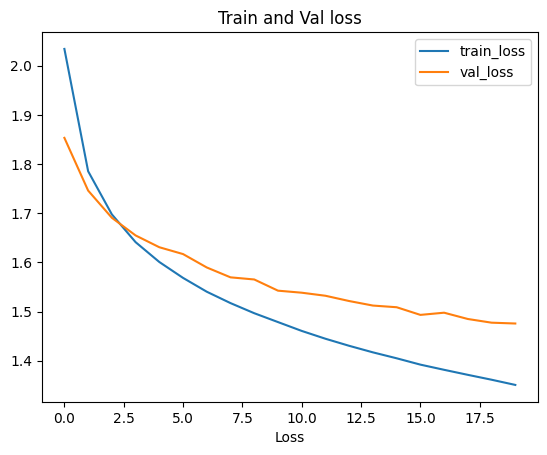

In [ ]:
plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
plt.title('Train and Val loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()

In [ ]:
def model_eval(model,testloader):
    with torch.no_grad():
        ys=[]
        outputs=[]
        for i, tdata in enumerate(testloader):
            tX,ty = tdata
            tX=tX.to(device)
            ty=ty.to(device)
            output = model.predict(tX)
            ys.append(ty.detach().cpu().numpy())
            outputs.append(output.detach().cpu().numpy())


    ys=np.hstack(ys)
    outputs= np.hstack(outputs)
    cm = sklearn.metrics.confusion_matrix(ys,outputs)
    print("****************************************************************************************")
    print("confusion matrix:")
    print(cm)

    print("****************************************************************************************")
    print("performance matrix:")
    print(sklearn.metrics.classification_report(ys,outputs))

In [ ]:
model_eval(model,testloader)

****************************************************************************************
confusion matrix:
[[550  41  50  28  21  14  27  41 169  59]
 [ 39 572  14  29  21  21  20  27  85 172]
 [ 78  28 333 105 113  68 134  79  33  29]
 [ 28  29  57 352  52 161 137  79  37  68]
 [ 46  20 104  90 350  47 152 120  34  37]
 [ 25  17  70 210  68 345  94  95  42  34]
 [  8  27  52 103  96  44 583  37  18  32]
 [ 38  28  39  60  75  71  42 556  19  72]
 [ 90  65  11  21  12  23  10  21 669  78]
 [ 38 149  10  32  16  18  34  41  74 588]]
****************************************************************************************
performance matrix:
              precision    recall  f1-score   support

           0       0.59      0.55      0.57      1000
           1       0.59      0.57      0.58      1000
           2       0.45      0.33      0.38      1000
           3       0.34      0.35      0.35      1000
           4       0.42      0.35      0.38      1000
           5       0.42     

# Train and test performance of model
- hyperparameter choice: lr = 5e-6, weight_decay = 5e-2, num_epochs  = 30
- build the model by calling the train_model function
- plot the training and validation loss curves
- get accuracy, confusion matrix and classification report on test data



In [ ]:
# your code to accomplish the steps above
lr = 1e-5
wd = 1e-2
num_epochs = 35

model = FiveLayerFC(32*32*3, 200, 200, 10, lr, wd).to(device)
model, train_loss, val_loss = train_model(model, trainloader, valloader, num_epochs)

  0%|          | 0/35 [00:00<?, ?it/s]

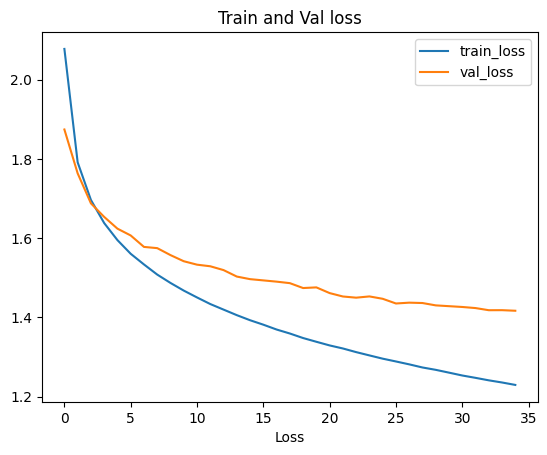

In [ ]:
# plot the validation and training loss curves
# your code here
plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
plt.title('Train and Val loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()


In [ ]:
model_eval(model,testloader)

****************************************************************************************
confusion matrix:
[[588  41  45  22  18  19  28  33 142  64]
 [ 31 625  15  23  14  12  23  25  72 160]
 [ 90  23 380  88 107  86 104  76  24  22]
 [ 36  27  77 342  47 200 121  63  27  60]
 [ 59  19 128  64 367  58 133 114  29  29]
 [ 24  17  82 206  59 402  71  79  30  30]
 [  6  20  66  99  87  58 587  25  16  36]
 [ 36  12  50  59  72  80  32 568  21  70]
 [ 89  72  10  24  13  23  10  18 667  74]
 [ 38 169  16  28  10  23  31  45  54 586]]
****************************************************************************************
performance matrix:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      1000
           1       0.61      0.62      0.62      1000
           2       0.44      0.38      0.41      1000
           3       0.36      0.34      0.35      1000
           4       0.46      0.37      0.41      1000
           5       0.42     

In [ ]:
torch.save(model, '/content/drive/MyDrive/FC2model.pth')

# Convolutional network
- complete the class definition below
- The network structure is provided. Feel free to modify it -- in which case, rename the class, and run the experiments below.
- The network structure is a sequence of three Conv2d, ReLU, Conv2D, ReLU, MaxPool2d, BatchNorm2d blocks.
- The final layers include two fully connected layers and an output layer with 10 units.


In [ ]:
class ConvModel(nn.Module):
    def __init__(self,lr,wd):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self,x):
        # forward propagate x through network
        # YOUR CODE HERE
        return self.net(x)

    def loss(self,yhat,y,averaged=True):
        # compute cross-entropy loss between network output and true labels y
        # averaged over a batch
        # YOUR CODE HERE
        loss = nn.functional.cross_entropy(yhat, y, reduction='mean' if averaged else 'none')
        return loss


    def predict(self,X):
        # return the index of the highest output in the output layer
        # YOUR CODE HERE
        return self.forward(X).argmax(axis=1)

    def configure_optimizers(self):
        # set up the Adam optimizer with default parameters and
        # model's learning rate and weight decay
        # YOUR CODE HERE
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)

# Train the model
- under two sets of hyperparameters

In [ ]:
lr = 1e-4
wd = 1e-1
num_epochs = 30


model = ConvModel(lr,wd).to(device)
model,train_loss,val_loss = train_model(model,trainloader,valloader,num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

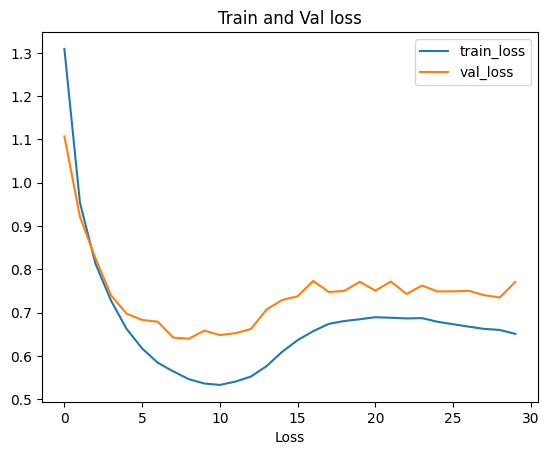

In [ ]:
# plot the validation and training loss curves
# your code here
plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
plt.title('Train and Val loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()


In [ ]:
# run the trained model on test data and report
# accuracy, confusion matrix and classification report
# your code here

model_eval(model,testloader)

****************************************************************************************
confusion matrix:
[[765   9  77  11  25   2   8  10  62  31]
 [ 26 822   7   2   0   5  24   2  24  88]
 [ 57   2 621  69  93  51  86  16   2   3]
 [ 11   0  33 711  43  75  93   9   9  16]
 [ 10   0  21  56 831   4  40  26  12   0]
 [  3   0  32 258  29 621  26  24   1   6]
 [  2   2  27  31  13   8 912   1   3   1]
 [  8   0  27  49  64  79  11 755   1   6]
 [ 76   6   4  26   7   2   8   0 840  31]
 [ 23  27   3  15   0  10   5   5  20 892]]
****************************************************************************************
performance matrix:
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      1000
           1       0.95      0.82      0.88      1000
           2       0.73      0.62      0.67      1000
           3       0.58      0.71      0.64      1000
           4       0.75      0.83      0.79      1000
           5       0.72     

In [ ]:
torch.save(model, '/content/drive/MyDrive/CNN1model.pth')

In [ ]:
# hyperparameter set 2

lr = 1e-3
wd = 1e-3
num_epochs = 20


model = ConvModel(lr,wd).to(device)
model,train_loss,val_loss = train_model(model,trainloader,valloader,num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

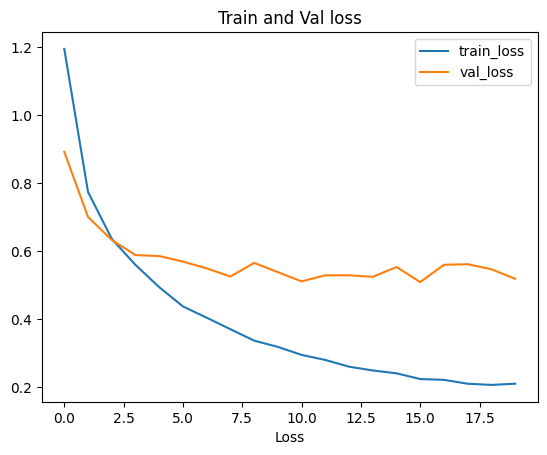

In [ ]:
# plot the validation and training loss curves
# your code here
# plot the validation and training loss curves
# your code here
plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
plt.title('Train and Val loss')
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend()



In [ ]:
# run the trained model on test data and report
# accuracy, confusion matrix and classification report
# your code here
model_eval(model,testloader)

****************************************************************************************
confusion matrix:
[[823  11  39  24  30   4   3  12  35  19]
 [ 10 900   3   6   2   4   3   0  13  59]
 [ 41   2 788  30  49  29  29  16  11   5]
 [ 20   2  59 655  51 126  45  19  20   3]
 [  9   2  66  35 825  20  12  24   7   0]
 [  2   1  67  96  28 769  12  19   2   4]
 [  4   0  57  46  21  21 834   4  11   2]
 [ 10   0  20  27  32  37   4 862   2   6]
 [ 40  13   7   8   2   2   4   1 903  20]
 [ 17  37   4  11   1   2   5   5  16 902]]
****************************************************************************************
performance matrix:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       0.93      0.90      0.91      1000
           2       0.71      0.79      0.75      1000
           3       0.70      0.66      0.68      1000
           4       0.79      0.82      0.81      1000
           5       0.76     

In [ ]:
torch.save(model, '/content/drive/MyDrive/CNN2model.pth')

# Comment on
- performance difference between multilayer feedforward and convolutional neural nets
- difference in the number of parameters between the two classes of deep models
- impact of learning rate and weight decay choice on the feedforward networks
- impact of learning rate and weight decay choice on convolutional networks
- experiment with these two hyperparameters to achieve > 50% accuracy with feedforward networks, and > 80% accuracy with convolutional networks


YOUR COMMENTS HERE

* **Performance Difference between MLP and CNN:** There is a distinct performance difference between the CNN and the feedforward network. While the best performance of the feedforward network is stagnated around 50% accuracy, the CNN produces values around 85% accuracy. \\
* **Number of parameters:** Based on the number if training parameters in the different architectures, CNN does have a higher number of parameters to optimize on due to its complex nature. \\
* **Feedforward: Learning Rate and weight decay**: While increasing the learning rate helps to an extent, beyond a point it tends to overshoot and cause divergence. Higher values of weight decay helps preventing overfitting, it also reduces model accuracy beyonf a certain threshold.
* **Convolution: Learning Rate and weight decay**: While the effects of both of these parameters are broadly similar, the rate of effect is different. increasing the learning rate beyond an optimal range causes drastic distortion in the output. Further, higher weight decays help prevent overfitting in a better manner. While lower weight decays are generally prefered, in cases where the dataset is small, it is essential to ensure overfitting does not occur